In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Ensure results directory exists
os.makedirs("monthly_results", exist_ok=True)

In [3]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [4]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
    'windspeed_10m',
    'windspeed_100m',
    'windgusts_10m',
    'Power_lag1', 
    'Power_lag3', 
    'Power_lag6', 
    'Power_lag12', 
    'Power_lag24',
    'Power_lag48', 
    'windspeed_10m_lag1', 
    'windspeed_10m_lag3',
    'windspeed_10m_lag6', 
    'windspeed_10m_lag12', 
    'windspeed_10m_lag24',
    'windspeed_100m_lag1', 
    'windspeed_100m_lag3', 
    'windspeed_100m_lag6',
    'windspeed_100m_lag12', 
    'windspeed_100m_lag24',
    'windgusts_10m_lag1',
    'windgusts_10m_lag3',
    'windgusts_10m_lag6',
    'windgusts_10m_lag12',
    'windgusts_10m_lag24'
]
target = 'Power'


In [6]:
# ===========================
# Lag Feature Generator (Location-aware)
# ===========================

def generate_lag_features(df, lags_dict):
    """
    df: dataframe with 'Location' and 'Time' columns
    lags_dict: dictionary with {column: [list of lags]}
    """
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Time')  # sort within each location
        
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    
    # Drop any rows that have NA values caused by shifting
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    
    return df_lagged


In [7]:
lags_dict = {
    'Power': [1, 3, 6, 12, 24, 48],  # Power has stronger longer lags (ACF showed high persistence)
    'windspeed_10m': [1, 3, 6, 12, 24],
    'windspeed_100m': [1, 3, 6, 12, 24],
    'windgusts_10m': [1, 3, 6, 12, 24],
}

In [8]:
# Apply lag feature generation
org_train_lagged = generate_lag_features(org_train, lags_dict)
aug_train_lagged = generate_lag_features(aug_train, lags_dict)
org_test_lagged = generate_lag_features(org_test, lags_dict)


In [9]:
X_train_org = org_train_lagged[features]
y_train_org = org_train_lagged[target]

X_train_aug = aug_train_lagged[features]
y_train_aug = aug_train_lagged[target]

In [10]:
# Define model hyperparameters
model_params = {
    'n_estimators': 200, 
    'max_depth': 20, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'random_state': 42
}

In [11]:
# KFold Cross-Validation function
def kfold_cross_validate(X, y, model_params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mae_scores, rmse_scores, r2_scores = [], [], []

    for train_index, val_index in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

        model = RandomForestRegressor(**model_params)
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)

        mae_scores.append(mean_absolute_error(y_val_cv, y_pred_cv))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)))
        r2_scores.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Cross-Validation Results (n_splits={n_splits}):")
    print(f"MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

In [ ]:
# =========================
# # KFold validation on Original data
# print("Original Data Cross-Validation:")
# kfold_cross_validate(X_train_org, y_train_org, model_params)

In [ ]:
# =========================
# KFold validation on Original data
# print("Original Data Cross-Validation:")
# kfold_cross_validate(X_train_org, y_train_org, model_params)

In [12]:
# =========================
# Final model training (train on full data after CV)
rf_org = RandomForestRegressor(**model_params)
rf_org.fit(X_train_org, y_train_org)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [13]:

rf_aug = RandomForestRegressor(**model_params)
rf_aug.fit(X_train_aug, y_train_aug)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [20]:
import joblib

file_name = '../weights'
os.makedirs(file_name,exist_ok=True)
# Save Random Forest models
joblib.dump(rf_org, f"{file_name}/rf_original_model.pkl")
joblib.dump(rf_aug, f"{file_name}/rf_augmented_model.pkl")

['../weights/rf_augmented_model.pkl']

In [15]:
# =========================
# Evaluation storage
all_results = []

# Get all unique locations
locations = org_test_lagged['Location'].unique()

for loc in locations:
    df_loc = org_test_lagged[org_test['Location'] == loc]
    
    # Iterate over months
    for month in range(1, 13):
        df_month = df_loc[df_loc['Timestamp'].dt.month == month]
        
        if df_month.empty:
            continue
        
        X_test = df_month[features]
        y_test = df_month[target]
        
        # Evaluate Original model
        y_pred_org = rf_org.predict(X_test)
        mae_org = mean_absolute_error(y_test, y_pred_org)
        rmse_org = np.sqrt(mean_squared_error(y_test, y_pred_org))
        r2_org = r2_score(y_test, y_pred_org)

        # Evaluate Augmented model
        y_pred_aug = rf_aug.predict(X_test)
        mae_aug = mean_absolute_error(y_test, y_pred_aug)
        rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_aug))
        r2_aug = r2_score(y_test, y_pred_aug)
        
        # Save results
        all_results.append({
            'Location': loc,
            'Month': month,
            'Model': 'Original',
            'MAE': mae_org,
            'RMSE': rmse_org,
            'R2': r2_org
        })

        all_results.append({
            'Location': loc,
            'Month': month,
            'Model': 'Augmented',
            'MAE': mae_aug,
            'RMSE': rmse_aug,
            'R2': r2_aug
        })
        
        # Save predictions for this location-month
        df_pred = df_month.copy()
        df_pred['Pred_Original'] = y_pred_org
        # df_pred['Pred_Augmented'] = y_pred_aug
        
        filename = f"monthly_results/{loc}_Month_{month:02d}.csv"
        df_pred.to_csv(filename, index=False)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_16238/1818356925.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_lagged[org_test['Location'] == loc]


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_16238/1818356925.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_lagged[org_test['Location'] == loc]
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_16238/1818356925.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_lagged[org_test['Location'] == loc]
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_16238/1818356925.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_lagged[org_test['Location'] == loc]


In [16]:
# Save full evaluation summary
results_df = pd.DataFrame(all_results)
# results_df.to_csv("monthly_results/full_evaluation_results.csv", index=False)

In [18]:
results_df['MAE'].mean()

0.019631008516336427

In [19]:
results_df['MAE'].std()

0.01286544619291148

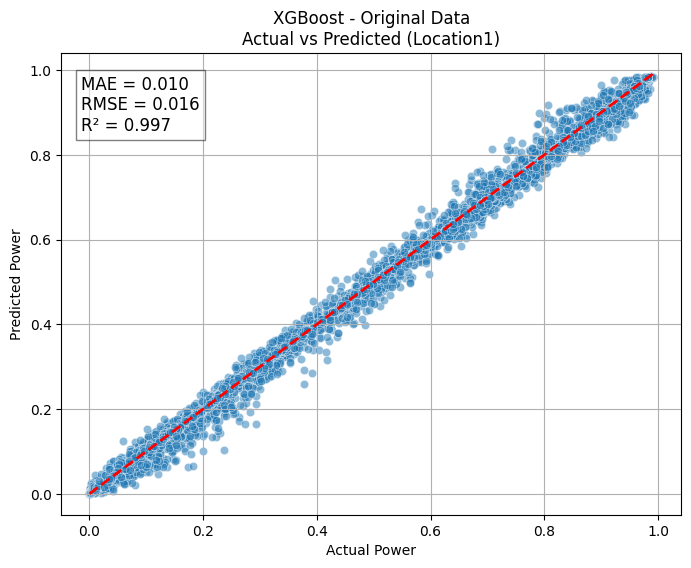

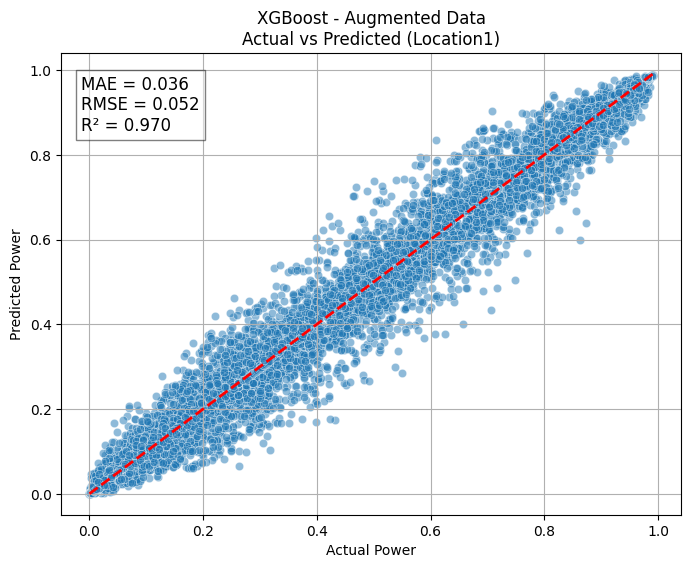

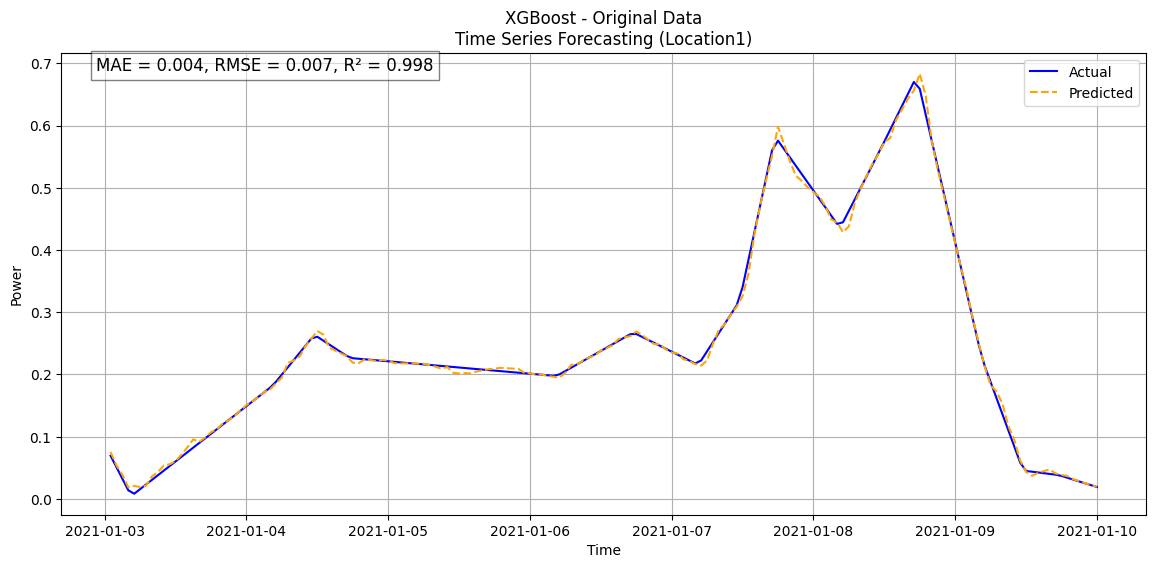

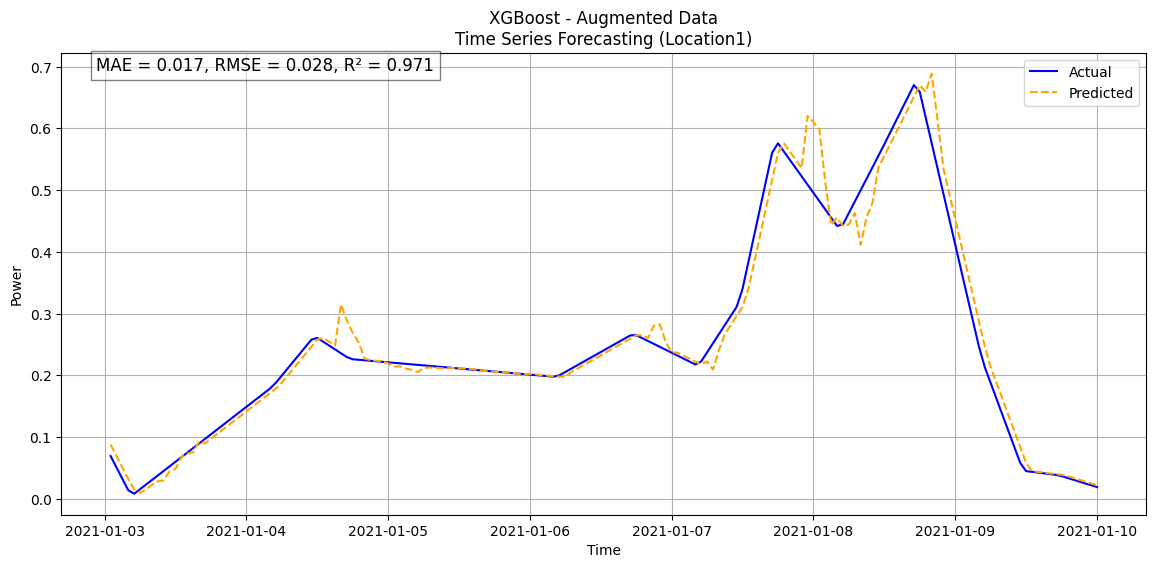

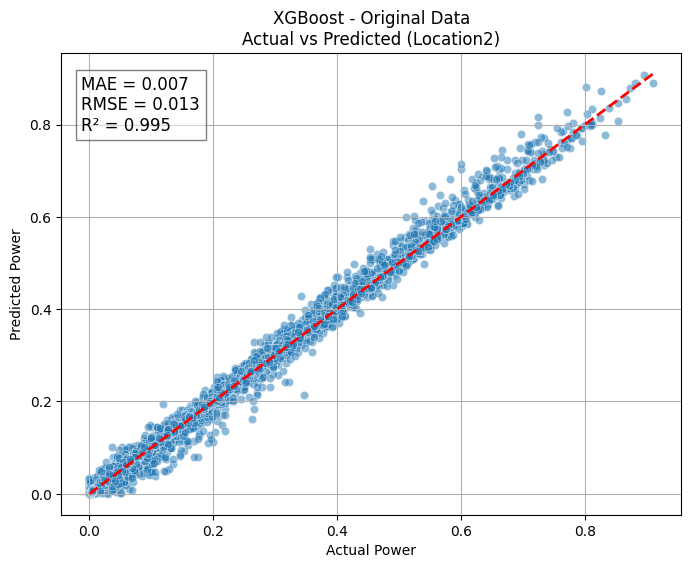

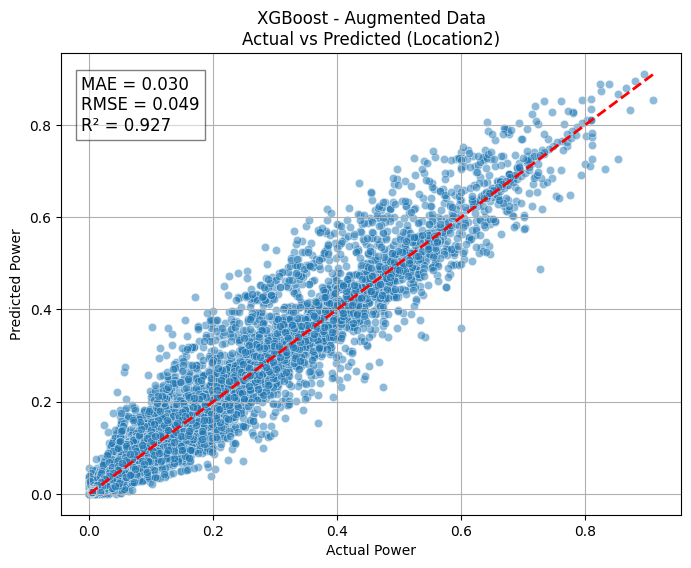

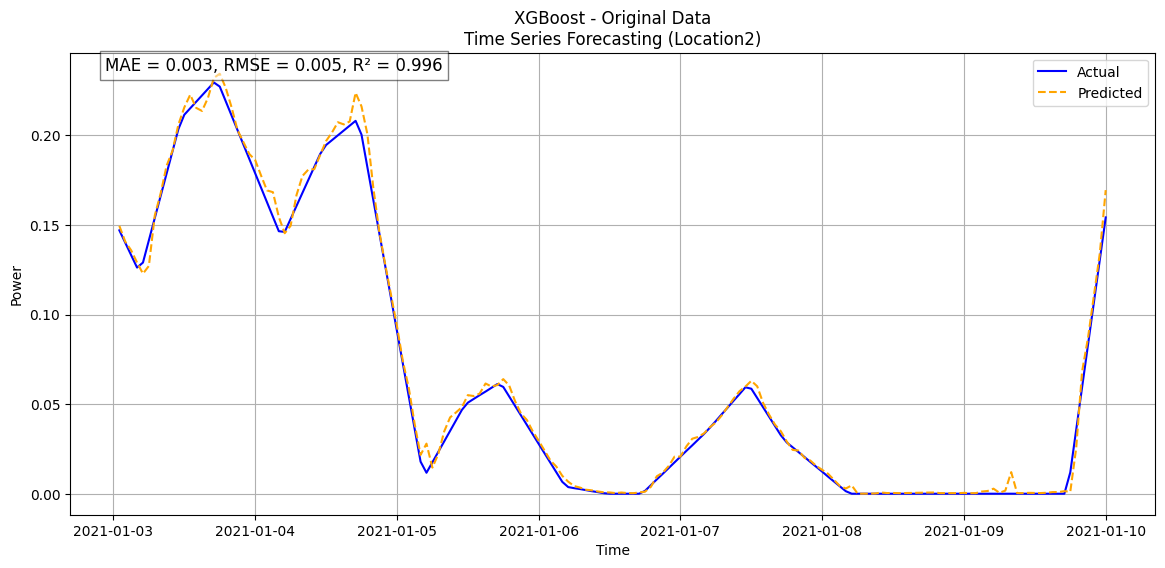

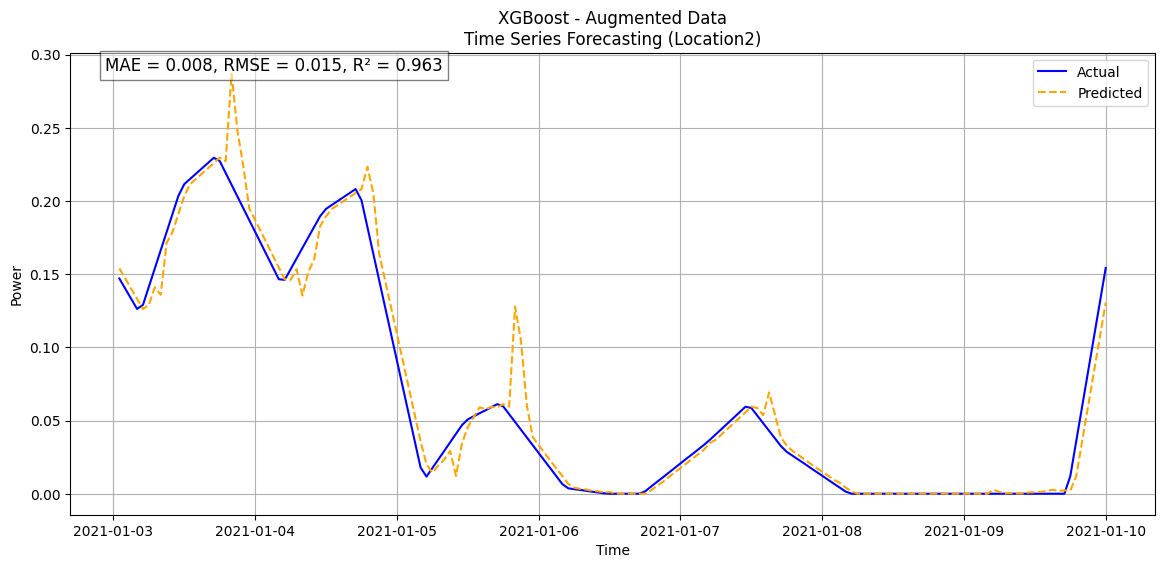

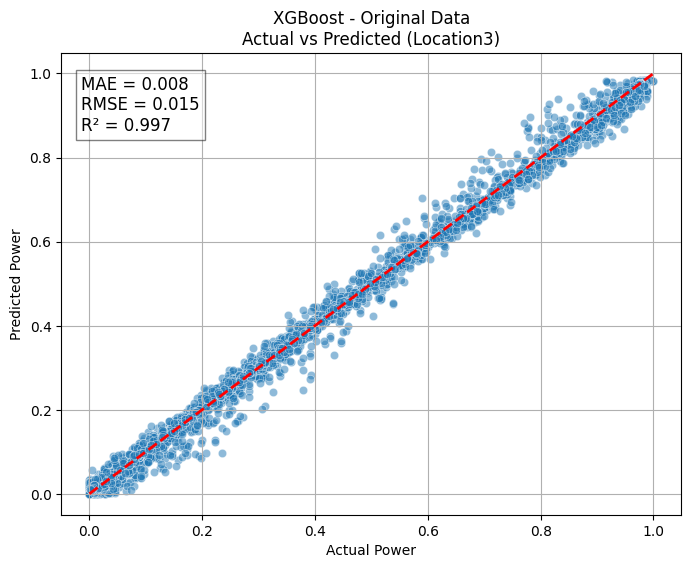

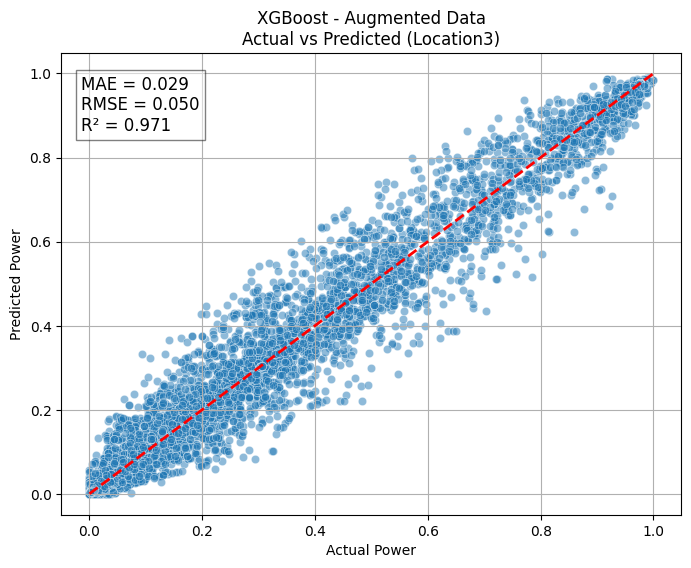

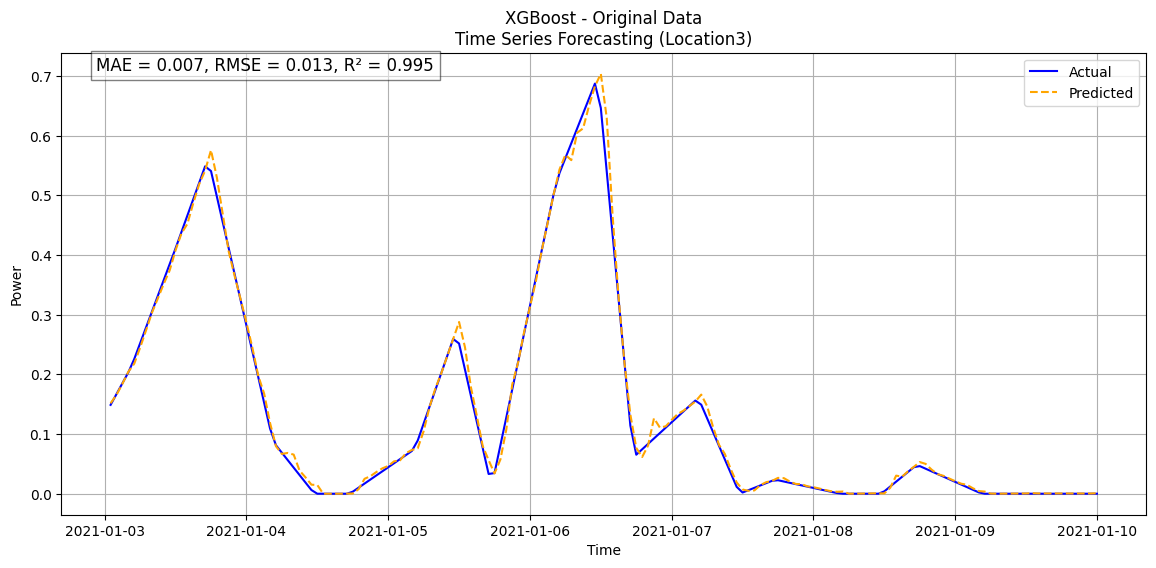

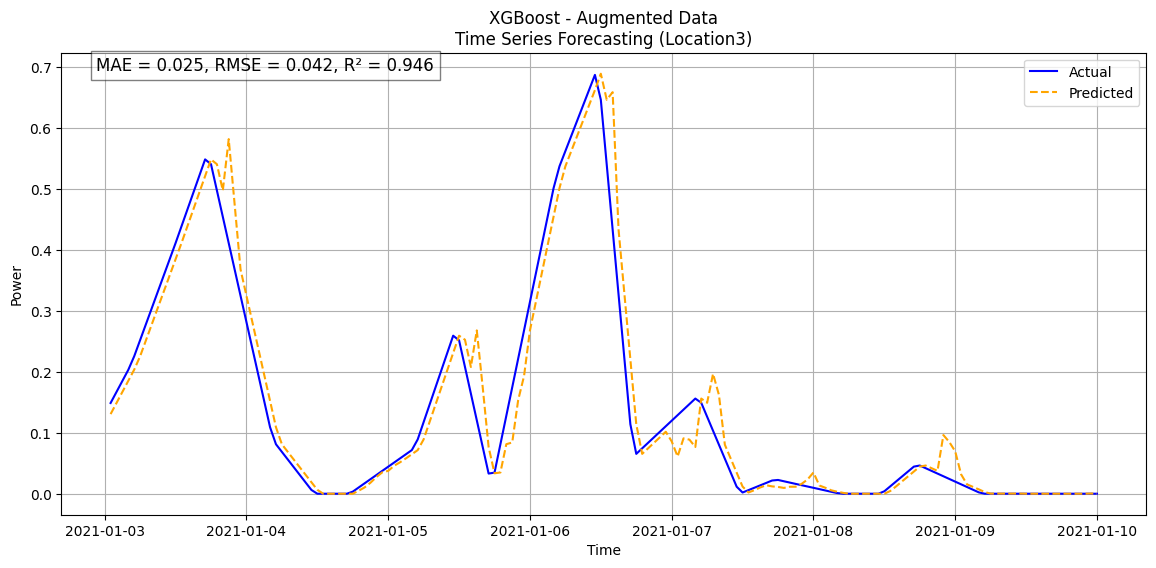

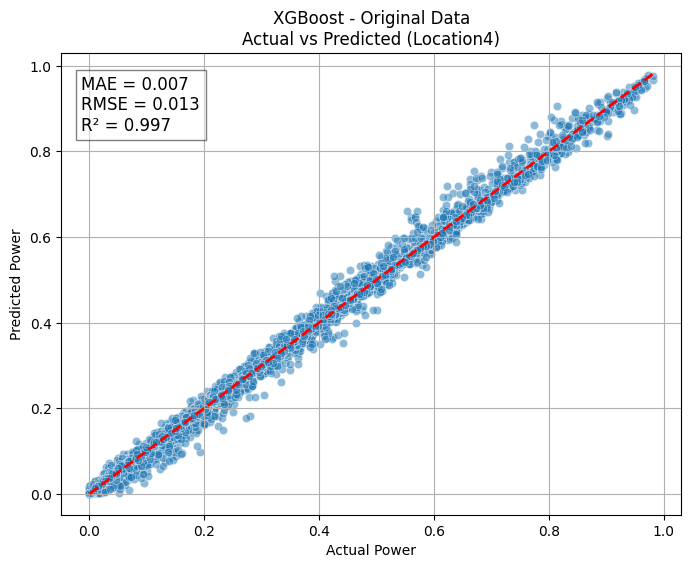

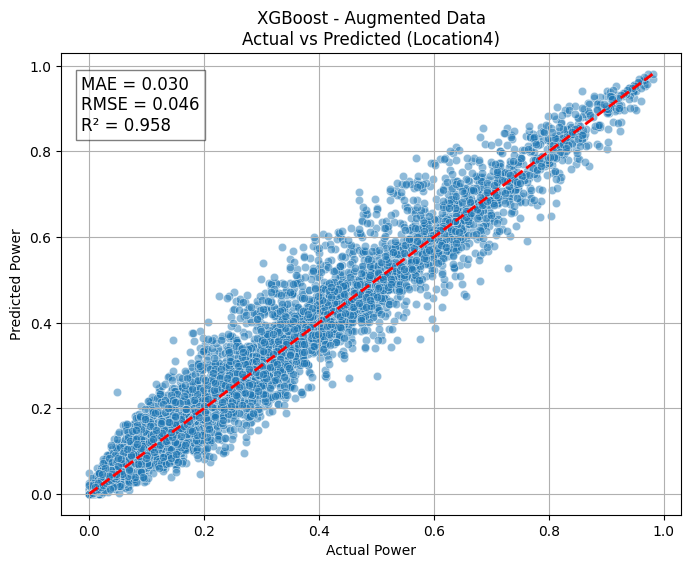

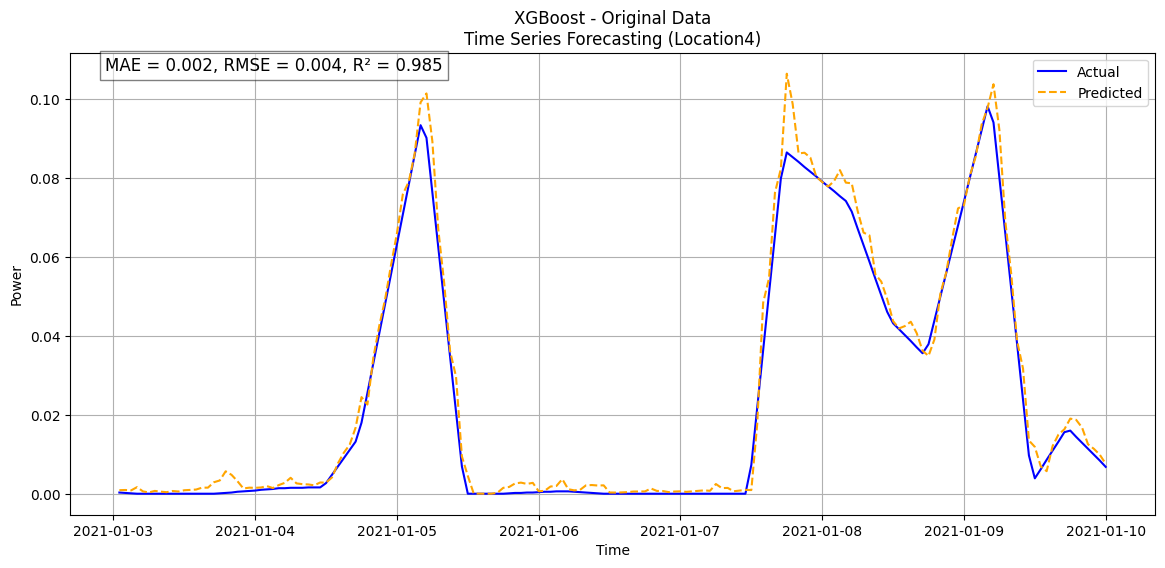

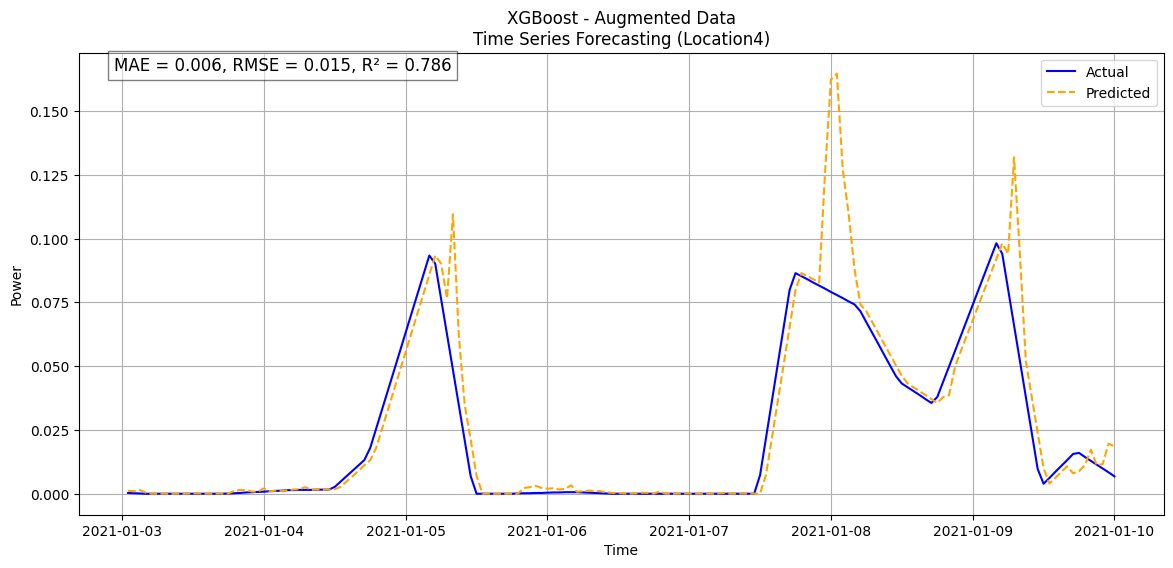

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =========
# Functions
# =========

def calculate_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power')
    plt.ylabel('Predicted Power')
    plt.title(f'{model_name} - {dataset_name}\nActual vs Predicted ({location})')
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
    plt.gcf().text(0.15, 0.75, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

def plot_timeseries(y_true, y_pred, timestamps, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, y_true, label='Actual', color='blue')
    plt.plot(timestamps, y_pred, label='Predicted', color='orange', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(f'{model_name} - {dataset_name}\nTime Series Forecasting ({location})')
    plt.legend()
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}"
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# =========
# Location-wise visualization
# =========

locations = org_test_lagged['Location'].unique()

for loc in locations:
    # Extract data for this location
    loc_mask = org_test_lagged['Location'] == loc
    X_test_loc = org_test_lagged[features][loc_mask]
    y_test_loc = org_test_lagged[target][loc_mask]
    timestamps_loc = org_test_lagged['Timestamp'][loc_mask]
    
    # Predictions
    y_pred_org = rf_org.predict(X_test_loc)
    y_pred_aug = rf_aug.predict(X_test_loc)
    
    # Scatter plots
    plot_actual_vs_predicted(y_test_loc, y_pred_org, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_actual_vs_predicted(y_test_loc, y_pred_aug, model_name='XGBoost', dataset_name='Augmented Data', location=loc)
    
    # Time series plots (only small subset for clarity)
    subset_size = 7*4*6  # 1 week if data hourly (adjust if needed)
    subset_X = X_test_loc.iloc[:subset_size]
    subset_y = y_test_loc.iloc[:subset_size]
    subset_t = timestamps_loc.iloc[:subset_size]
    
    y_pred_org_subset = rf_org.predict(subset_X)
    y_pred_aug_subset = rf_aug.predict(subset_X)
    
    plot_timeseries(subset_y, y_pred_org_subset, subset_t, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_timeseries(subset_y, y_pred_aug_subset, subset_t, model_name='XGBoost', dataset_name='Augmented Data', location=loc)
